In [ ]:
!pip3 install transformers
!pip3 install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 163 kB 12.4 MB/s 
     |████████████████████████████████| 7.6 MB 25.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=853def717331abb967a428a689baba0837c6bfccafda6123f5cd3d76a53a852b
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [ ]:
!pip3 install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn

In [ ]:
import torch
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer 
import tensorflow as tf
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import locale

import os
import time

In [ ]:
# Clone github repo containing the data as csv file
! rm -rf covid_data
! git clone https://github.com/PatrickNiccolai2/covid_data

Cloning into 'covid_data'...
remote: Enumerating objects: 2040, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 2040 (delta 24), reused 90 (delta 22), pack-reused 1948
Receiving objects: 100% (2040/2040), 334.22 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
# Download the tweets with sentiment data
!unzip /content/covid_data/tweets_with_lang -d /content/covid_data/unzip_tweets_with_lang

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_80172.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_8455.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_54445.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_65840.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_7766.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_74795.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_23815.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_tweet_43139.txt  
  inflating: /content/covid_data/unzip_tweets_with_lang/tweets_with_lang/lang_sent_shuffled_twe

In [ ]:
# Read all of the tweets + other data into an array
all_files_text = []

# Iterate through folder we just unzipped
for filename in os.listdir("/content/covid_data/unzip_tweets_with_lang/tweets_with_lang"):
  if(filename[0] == "l"):
    # Open each file and read it
    file_path = "/content/covid_data/unzip_tweets_with_lang/tweets_with_lang/" + filename
    file = open(file_path, "r")
    lines = file.read()

    # Split the file into different parts
    lines_arr = lines.split("\n\n")
    lang = lines_arr[-1]
    sent = lines_arr[-2]
    id = lines_arr[-3]
    place = lines_arr[-5]
    coords = lines_arr[-5]
    time = lines_arr[-6]

    tweet_text = ""
    for i in range(7, len(lines_arr) + 1):
      tweet_text = tweet_text + lines_arr[-i]

    # Search the tweet text for a manufacturer, if one is mentioned
    if("johnson" not in tweet_text.lower()):
      man = "no_man"
      if("sputnik" in tweet_text.lower()):
        man = "sputnik"
      if("sinopharm" in tweet_text.lower() or "sinovac" in tweet_text.lower()):
        man = "sino"
      if("moderna" in tweet_text.lower() or "spikevax" in tweet_text.lower()):
        man = "moderna"
      if("pfizer" in tweet_text.lower() or "biontech" in tweet_text.lower() or "comirnaty" in tweet_text.lower()):
        man = "pfizer"
      if("janssen" in tweet_text.lower()):
        man = "janssen"
      if("astrazeneca" in tweet_text.lower() or "vaxzevria" in tweet_text.lower()):
        man = "astra"
        
      # Add all the info from the file to all_files_text
      full_tweet = [tweet_text, time, coords, place, id, man, sent, lang]
      all_files_text.append(full_tweet)
    file.close()


In [ ]:
# This is how many tweets we have
print(len(all_files_text))

114549


In [ ]:
# Create a dataframe with all of the data
all_tweets_df = pd.DataFrame(all_files_text, columns=["tweet_text", "time", "coords", "place", "tweet_id", "man", "sentiment", "language"])
all_tweets_df = all_tweets_df.drop_duplicates(subset='tweet_id', keep="first")
all_tweets_df = all_tweets_df.loc[all_tweets_df["language"] == "en"]

In [ ]:
print(all_tweets_df.head(10))

                                          tweet_text  \
0  Vaccine shot # 2 in the books ✅✅💉💉\nQuick &amp...   
1  @hardik95_ @DevPalkar I didn’t get get this SM...   
2  Girl next to me at the vaccine clinic has a Kn...   
3  Can you.?If you can.Plz drop your number i wil...   
4  @AlphaNewsMN @afbranco Now do the one where th...   
5  @CNBC All these labs looking for a vaccine and...   
6  #china says they have begun hospitalized trial...   
7  Worldwide measles deaths climbed 50% from 2016...   
8  @ZubyMusic Spot on and these are actual vaccines.   
9  Galvez shows the COVID-19 vaccine roadmap stra...   

                        time coords place             tweet_id     man  \
0  2021-05-03 14:28:50+00:00   None  None  1389225443711229955  no_man   
1  2021-01-15 12:35:59+00:00   None  None  1350059153398456321  no_man   
2  2021-05-24 19:58:04+00:00   None  None  1396918440095539200  no_man   
3  2021-04-21 13:48:13+00:00   None  None  1384866565993254913  no_man   
4  2021-07-05

In [ ]:
# Convert strings to datetime so they can be used
def str_to_datetime(in_str):
  date = in_str.split(" ")[0]
  out_datetime = datetime.strptime(date,"%Y-%m-%d")
  return out_datetime

all_tweets_df["datetime"] = all_tweets_df["time"].apply(str_to_datetime)

In [ ]:
# The sentiment is an array containing 3 values, convert it to one value
def sent_arr_to_val(sent_str):
  sent_str = sent_str[2:-2]
  sent_arr = sent_str.split()
    # We define the sentiment value as probability of positive sentiment minus probability of negative sentiment
  return float(sent_arr[2]) - float(sent_arr[0])

all_tweets_df["sent_avg"] = all_tweets_df["sentiment"].apply(sent_arr_to_val)

In [ ]:
print(all_tweets_df.head(10))

                                          tweet_text  \
0  Vaccine shot # 2 in the books ✅✅💉💉\nQuick &amp...   
1  @hardik95_ @DevPalkar I didn’t get get this SM...   
2  Girl next to me at the vaccine clinic has a Kn...   
3  Can you.?If you can.Plz drop your number i wil...   
4  @AlphaNewsMN @afbranco Now do the one where th...   
5  @CNBC All these labs looking for a vaccine and...   
6  #china says they have begun hospitalized trial...   
7  Worldwide measles deaths climbed 50% from 2016...   
8  @ZubyMusic Spot on and these are actual vaccines.   
9  Galvez shows the COVID-19 vaccine roadmap stra...   

                        time coords place             tweet_id     man  \
0  2021-05-03 14:28:50+00:00   None  None  1389225443711229955  no_man   
1  2021-01-15 12:35:59+00:00   None  None  1350059153398456321  no_man   
2  2021-05-24 19:58:04+00:00   None  None  1396918440095539200  no_man   
3  2021-04-21 13:48:13+00:00   None  None  1384866565993254913  no_man   
4  2021-07-05

In [ ]:
# This cells creates a new dataframe with a row for each day, containing the average
# sentiment value and the variacnce of sentiment values for that day

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

all_tweets_df["sent_var"] = all_tweets_df["sent_avg"]

samples_per_day_df = all_tweets_df.groupby(["datetime"]).agg(aggregator)
samples_per_day_df = samples_per_day_df.sort_index()
samples_per_day_df.reset_index(inplace=True)
samples_per_day_df = samples_per_day_df.rename(columns = {'index':'datetime'})
print(samples_per_day_df.head(-10))

      datetime  tweet_text  time  coords  tweet_id  sentiment  sent_avg  \
0   2019-11-19          11    11      11        11         11 -0.158187   
1   2019-11-20          12    12      12        12         12 -0.187530   
2   2019-11-21           4     4       4         4          4 -0.406419   
3   2019-11-22           7     7       7         7          7  0.057311   
4   2019-11-23           8     8       8         8          8 -0.367890   
..         ...         ...   ...     ...       ...        ...       ...   
646 2021-08-26         328   328     328       328        328 -0.367181   
647 2021-08-27         290   290     290       290        290 -0.384501   
648 2021-08-28         257   257     257       257        257 -0.348154   
649 2021-08-29         246   246     246       246        246 -0.414808   
650 2021-08-30         237   237     237       237        237 -0.410470   

     sent_var  
0    0.561319  
1    0.396492  
2    0.267958  
3    0.226158  
4    0.136603  
.. 

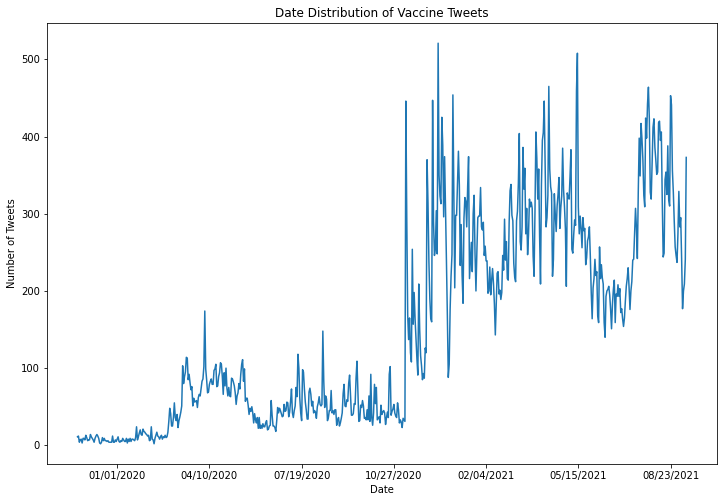

In [ ]:
# Plot date distribution of tweets we collected
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(samples_per_day_df["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Date Distribution of Vaccine Tweets")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(samples_per_day_df["datetime"],samples_per_day_df["tweet_text"])
plt.show()

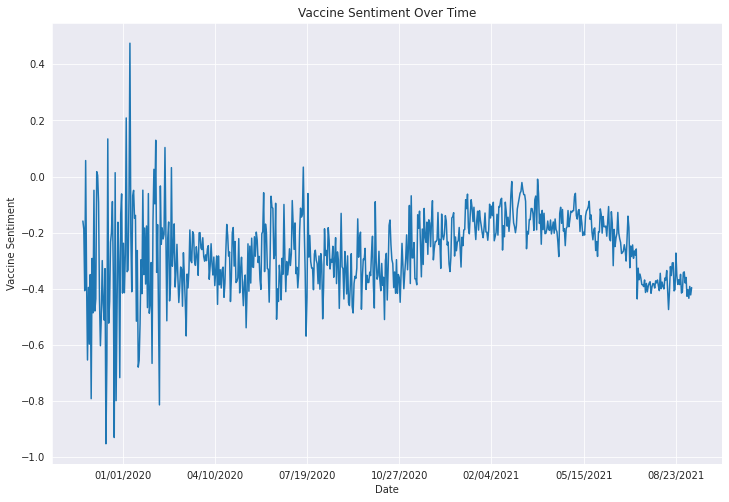

In [ ]:
# Plot average vaccine sentiment per day
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(samples_per_day_df["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Vaccine Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(samples_per_day_df["datetime"],samples_per_day_df["sent_avg"].ewm(span = 1).mean())
plt.show()

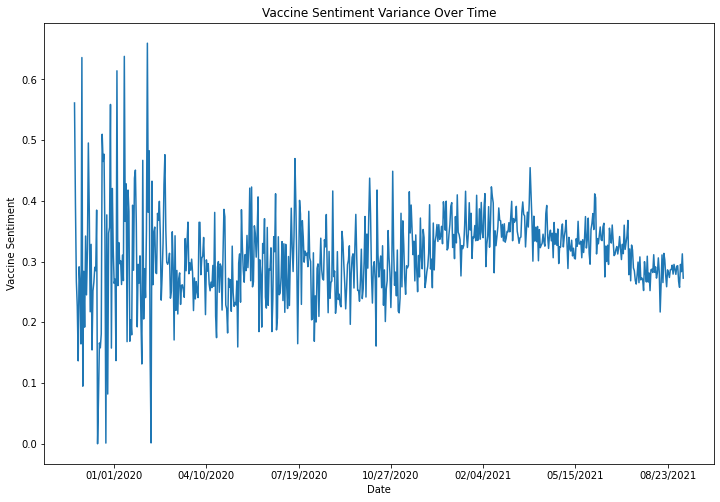

In [ ]:
# Plot variance in vaccine sentiment per day
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(samples_per_day_df["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Vaccine Sentiment Variance Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(samples_per_day_df["datetime"],samples_per_day_df["sent_var"])
plt.show()

In [ ]:
# Xiaoyu's analysis for covid new variant burst vs sentiment
# alpha_beta_burst_time = [395, 415]
alpha_beta_burst_time = [345, 455]
alpha_beta_burst = samples_per_day_df[alpha_beta_burst_time[0]: alpha_beta_burst_time[1]]
alpha_beta_burst_time_data = alpha_beta_burst['datetime']


#gamma_burst_time = [419,439]
gamma_burst_time = [369,469]
gamma_burst = samples_per_day_df[gamma_burst_time[0]:gamma_burst_time[1]]
gamma_burst_time_data = gamma_burst['datetime']

#delta_burst_time = [502,522]
delta_burst_time = [452,552]
delta_burst = samples_per_day_df[delta_burst_time[0]: delta_burst_time[1]]
delta_burst_time_data = delta_burst['datetime']
#gamma_burst['sentiment'].plot(kind = 'line')

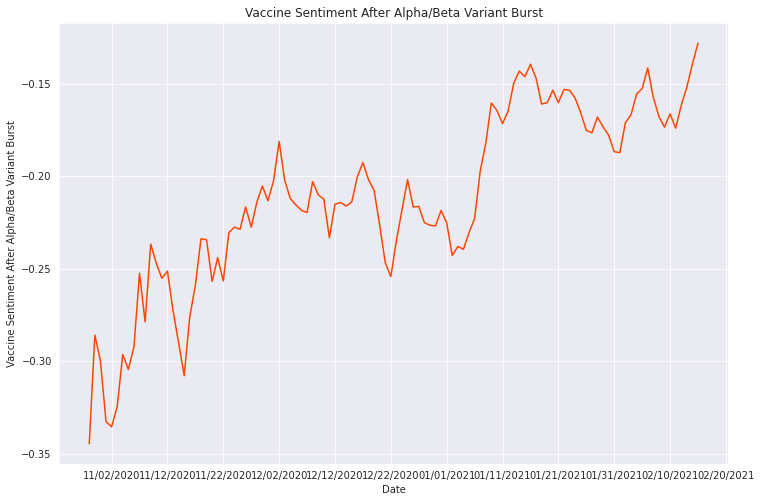

In [ ]:
#Plot Alpha/Beta data
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment After Alpha/Beta Variant Burst")
plt.xticks(alpha_beta_burst["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.title("Vaccine Sentiment After Alpha/Beta Variant Burst")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(alpha_beta_burst["datetime"],alpha_beta_burst["sent_avg"].ewm(span = 10).mean(), 'orangered')
plt.show()

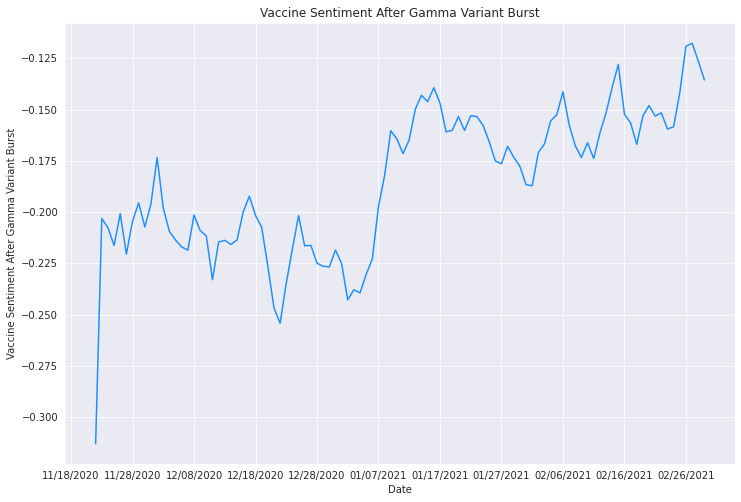

In [ ]:
#Plot Gamma data
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment After Gamma Variant Burst")
plt.xticks(gamma_burst["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.title("Vaccine Sentiment After Gamma Variant Burst")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(gamma_burst["datetime"],gamma_burst["sent_avg"].ewm(span = 10).mean(), 'dodgerblue')
plt.show()

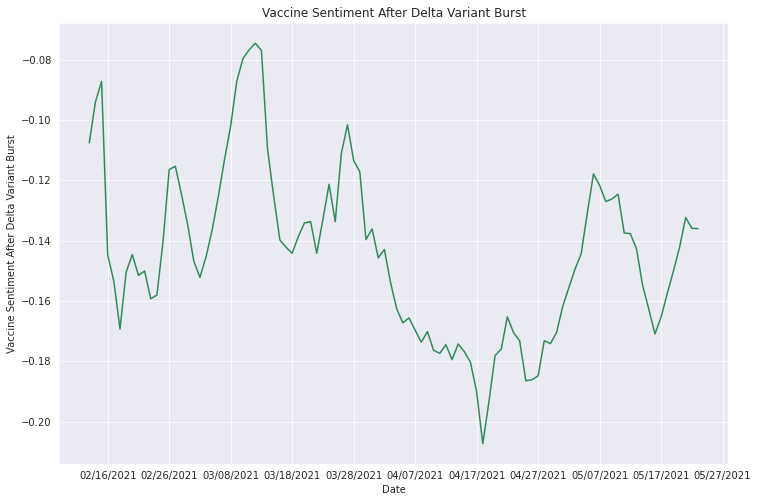

In [ ]:
#Plot Gamma data
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment After Delta Variant Burst")
plt.xticks(delta_burst["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
# plt.axvline(1)
plt.title("Vaccine Sentiment After Delta Variant Burst")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(delta_burst["datetime"],delta_burst["sent_avg"].ewm(span = 10).mean(),'seagreen')
plt.show()

In [ ]:
# This cell counts how many tweets mention a manufacturer

num_sputnik = 0
num_sino = 0
num_moderna = 0
num_pfizer = 0
num_janssen = 0
num_astra = 0

sputnik_arr = []
sino_arr = []
moderna_arr = []
pfizer_arr = []
janssen_arr = []
astra_arr = []
for file in all_files_text:
  tweet_text = file[0]
  if("sputnik" in tweet_text.lower()):
    num_sputnik += 1
    sputnik_arr.append(file)
  if("sinopharm" in tweet_text.lower() or "sinovac" in tweet_text.lower()):
    num_sino += 1
    sino_arr.append(file)
  if("moderna" in tweet_text.lower() or "spikevax" in tweet_text.lower()):
    num_moderna += 1
    moderna_arr.append(file)
  if("pfizer" in tweet_text.lower() or "biontech" in tweet_text.lower() or "comirnaty" in tweet_text.lower()):
    num_pfizer += 1
    pfizer_arr.append(file)
  if("janssen" in tweet_text.lower() or "johnson" in tweet_text.lower()):
    num_janssen += 1
    janssen_arr.append(file)
  if("astrazeneca" in tweet_text.lower() or "vaxzevria" in tweet_text.lower()):
    num_astra += 1
    astra_arr.append(file)

print("sputnik: " + str(num_sputnik))
print("sino: " + str(num_sino))
print("moderna: " + str(num_moderna))
print("pfizer: " + str(num_pfizer))
print("janssen: " + str(num_janssen))
print("astrazeneca: " + str(num_astra))

sputnik: 701
sino: 676
moderna: 1975
pfizer: 5140
janssen: 107
astrazeneca: 1832


In [ ]:
# Create a dataframe of only moderna tweets
moderna_df = all_tweets_df[all_tweets_df["man"] == "moderna"]

In [ ]:
# Create a dataframe of only moderna tweets grouped by day
aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

moderna_per_day = moderna_df.groupby(["datetime"]).agg(aggregator)
moderna_per_day = moderna_per_day.sort_index()
moderna_per_day.reset_index(inplace=True)
moderna_per_day = moderna_per_day.rename(columns = {'index':'datetime'})

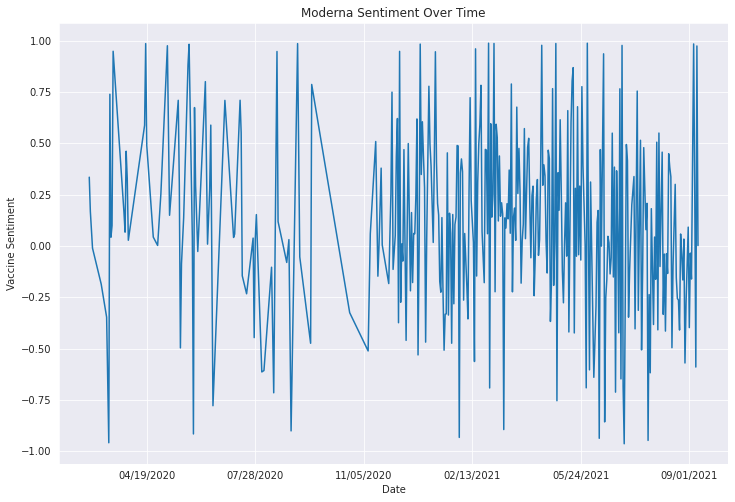

In [ ]:
# Plot sentiment by day for moderna
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(moderna_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Moderna Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(moderna_per_day["datetime"],moderna_per_day["sent_avg"])
plt.show()

In [ ]:
# Do same thing for pfizer
pfizer_df = all_tweets_df[all_tweets_df["man"] == "pfizer"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

pfizer_per_day = pfizer_df.groupby(["datetime"]).agg(aggregator)
pfizer_per_day = pfizer_per_day.sort_index()
pfizer_per_day.reset_index(inplace=True)
pfizer_per_day = pfizer_per_day.rename(columns = {'index':'datetime'})

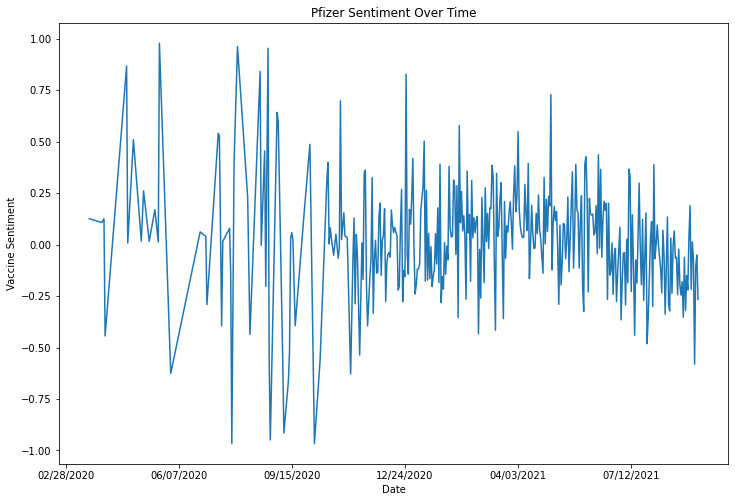

In [ ]:
# Plot sentiment per day for pfizer
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(pfizer_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Pfizer Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(pfizer_per_day["datetime"],pfizer_per_day["sent_avg"])
plt.show()

In [ ]:
# Do same thing for astrazenca
astra_df = all_tweets_df[all_tweets_df["man"] == "astra"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

astra_per_day = astra_df.groupby(["datetime"]).agg(aggregator)
astra_per_day = astra_per_day.sort_index()
astra_per_day.reset_index(inplace=True)
astra_per_day = astra_per_day.rename(columns = {'index':'datetime'})

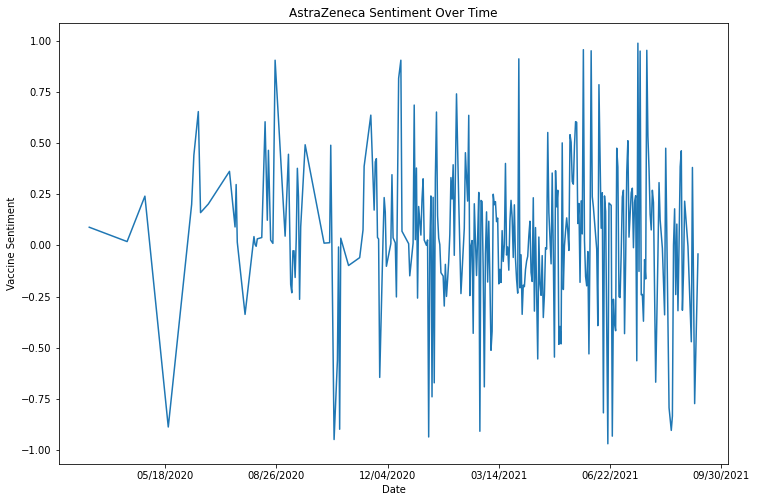

In [ ]:
# Plot sentiment per day for astrazeneca
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(astra_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("AstraZeneca Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(astra_per_day["datetime"],astra_per_day["sent_avg"])
plt.show()

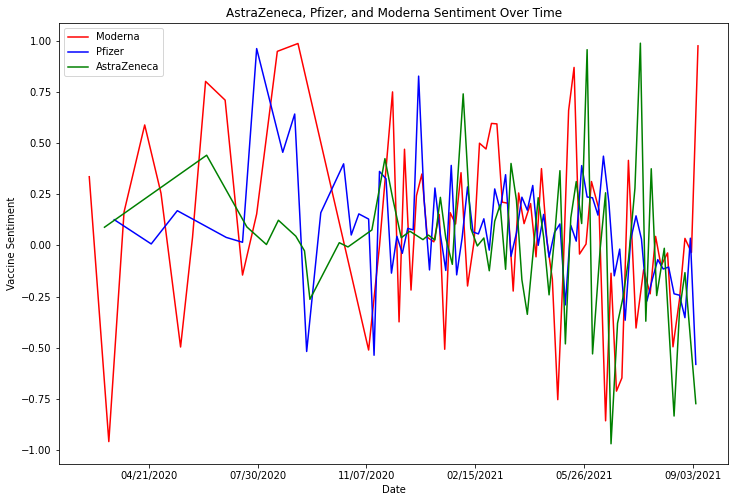

In [ ]:
# all the sentiments on one plot over time for the baseline 

# how to make this only plot from Dec 2020 to March 2021?
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(astra_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("AstraZeneca, Pfizer, and Moderna Sentiment Over Time")

ax.plot(moderna_per_day["datetime"][::5],moderna_per_day["sent_avg"][::5],'red', label='Moderna')
ax.plot(pfizer_per_day["datetime"][::5],pfizer_per_day["sent_avg"][::5],'blue', label='Pfizer')
ax.plot(astra_per_day["datetime"][::5],astra_per_day["sent_avg"][::5],'green', label='AstraZeneca')
leg = ax.legend()

In [ ]:
# alpha_beta_burst_time = [91,111]
# delta_burst_time = [114,134]
# gamma_burst_time = [194,214]


alpha_beta_burst_time = [41,141]
delta_burst_time = [74,174]
gamma_burst_time = [144,244]

In [ ]:
moderna_per_day_alpha_beta = moderna_per_day[alpha_beta_burst_time[0]: alpha_beta_burst_time[1]]
# pfizer_per_day_alpha_beta = pfizer_per_day[103:123]
# astra_per_day_alpha_beta = astra_per_day[70:90]

pfizer_per_day_alpha_beta = pfizer_per_day[53:153]
astra_per_day_alpha_beta = astra_per_day[20:120]

In [ ]:
# moderna_per_day_gamma = moderna_per_day[114: 134]
# pfizer_per_day_gamma = pfizer_per_day[127:147]
# astra_per_day_gamma = astra_per_day[87:107]

moderna_per_day_gamma = moderna_per_day[64: 164]
pfizer_per_day_gamma = pfizer_per_day[77:177]
astra_per_day_gamma = astra_per_day[37:137]

In [ ]:
# moderna_per_day_delta = moderna_per_day[194: 214]
# pfizer_per_day_delta = pfizer_per_day[210:230]
# astra_per_day_delta = astra_per_day[165:185]

moderna_per_day_delta = moderna_per_day[144: 244]
pfizer_per_day_delta = pfizer_per_day[160:260]
astra_per_day_delta = astra_per_day[105:205]

In [ ]:
seaborn.set_style('darkgrid')
seaborn.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [ ]:
# xiaoyu's sentiment analysis towards different types vaccine.

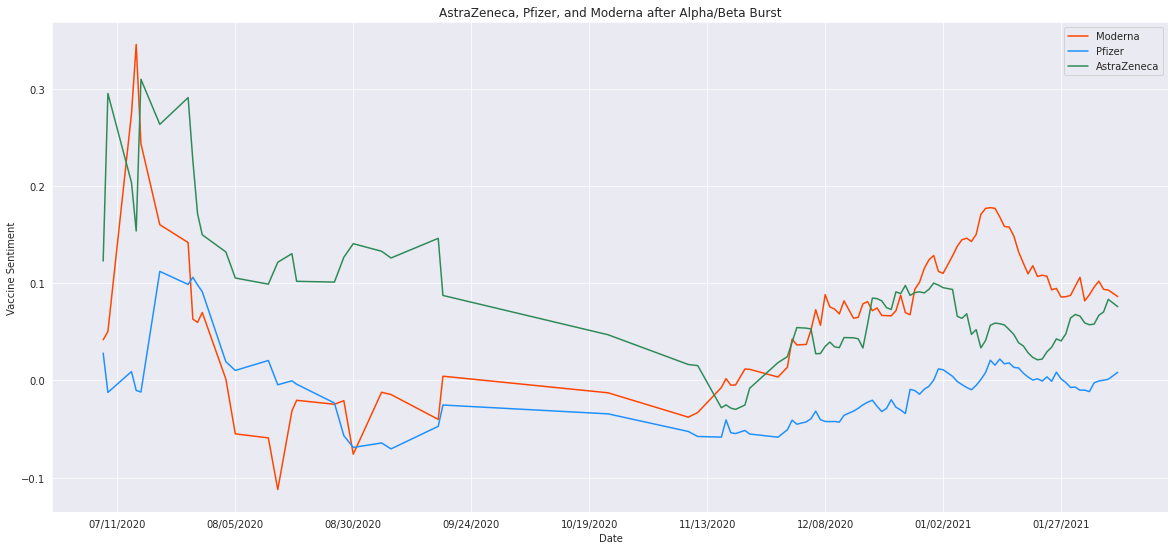

In [ ]:
dfig, ax = plt.subplots(figsize = (20, 10)) 
# fig.set_figheight(9)
# fig.set_figwidth(30)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(moderna_per_day_alpha_beta["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()
plt.title("AstraZeneca, Pfizer, and Moderna after Alpha/Beta Burst")

ax.plot(moderna_per_day_alpha_beta["datetime"],moderna_per_day_alpha_beta["sent_avg"].ewm(span = 100).mean(),'orangered', label='Moderna')
ax.plot(moderna_per_day_alpha_beta["datetime"],pfizer_per_day_alpha_beta["sent_avg"].ewm(span = 100).mean(),'dodgerblue', label='Pfizer')
ax.plot(moderna_per_day_alpha_beta["datetime"],astra_per_day_alpha_beta["sent_avg"].ewm(span = 100).mean(),'seagreen', label='AstraZeneca')

leg = ax.legend()

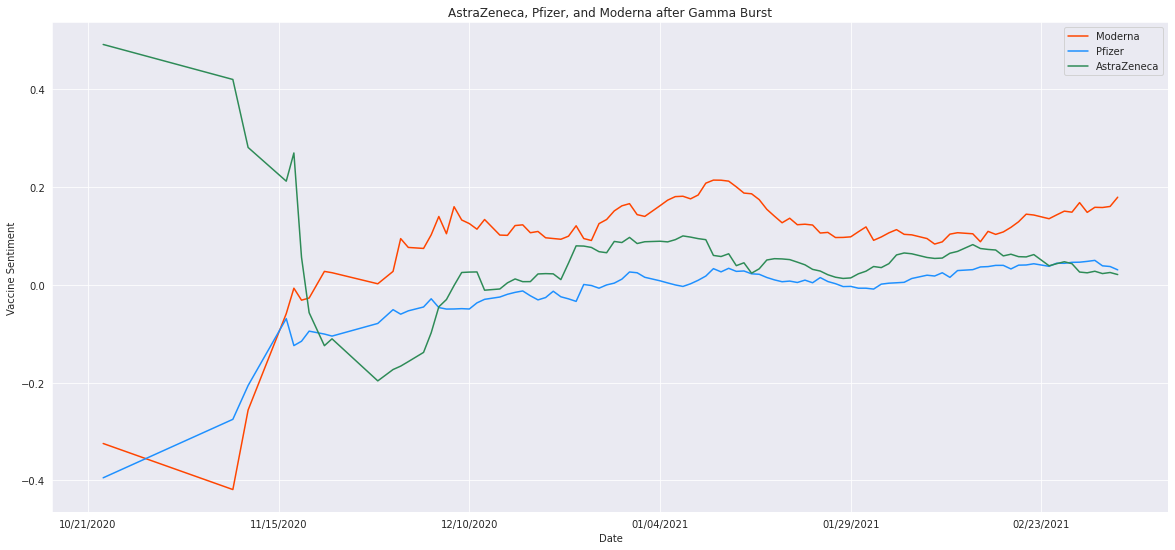

In [ ]:
dfig, ax = plt.subplots(figsize = (20, 10)) 
# fig.set_figheight(9)
# fig.set_figwidth(30)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(moderna_per_day_gamma["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()
plt.title("AstraZeneca, Pfizer, and Moderna after Gamma Burst")

ax.plot(moderna_per_day_gamma["datetime"],moderna_per_day_gamma["sent_avg"].ewm(span = 100).mean(),'orangered', label='Moderna')
ax.plot(moderna_per_day_gamma["datetime"],pfizer_per_day_gamma["sent_avg"].ewm(span = 100).mean(),'dodgerblue', label='Pfizer')
ax.plot(moderna_per_day_gamma["datetime"],astra_per_day_gamma["sent_avg"].ewm(span = 100).mean(),'seagreen', label='AstraZeneca')
leg = ax.legend()

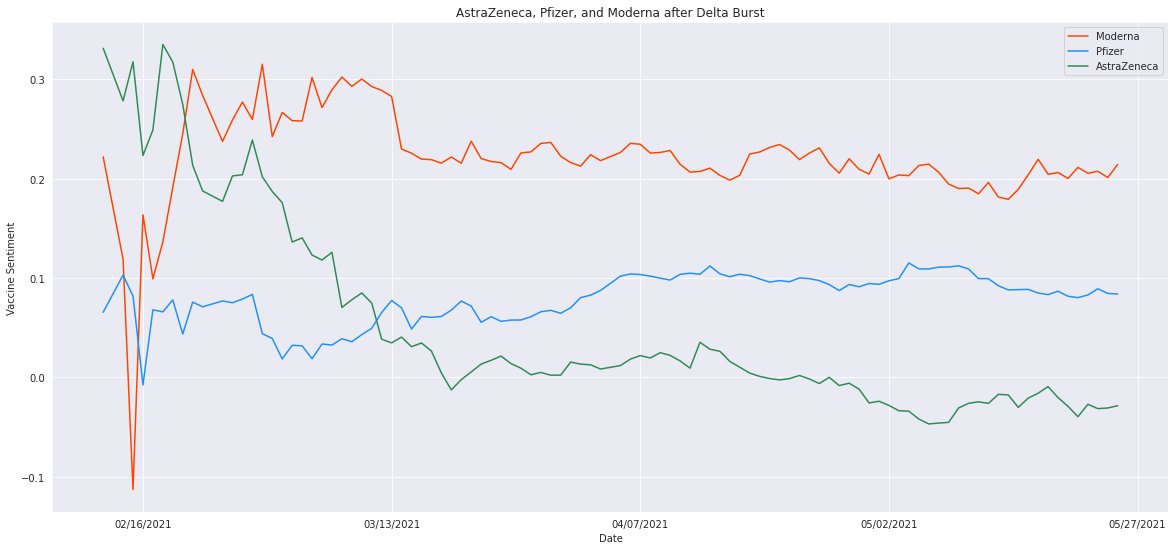

In [ ]:
dfig, ax = plt.subplots(figsize = (20, 10)) 
# fig.set_figheight(9)
# fig.set_figwidth(30)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(moderna_per_day_delta["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()
plt.title("AstraZeneca, Pfizer, and Moderna after Delta Burst")

ax.plot(moderna_per_day_delta["datetime"],moderna_per_day_delta["sent_avg"].ewm(span = 100).mean(),'orangered', label='Moderna')
ax.plot(moderna_per_day_delta["datetime"],pfizer_per_day_delta["sent_avg"].ewm(span = 100).mean(),'dodgerblue', label='Pfizer')
ax.plot(moderna_per_day_delta["datetime"],astra_per_day_delta["sent_avg"].ewm(span = 100).mean(),'seagreen', label='AstraZeneca')
leg = ax.legend()

In [ ]:
# compare to baseline
# calculate mean score for moderna 
  # December 2020 - 0.368±0.450
  # January 2021 -  0.119±0.532
  # febuary 2021 -  0.312±0.144
  # march 2021 - 0.397±0.166

# calculate mean score for pfizer 
  # December 2020 - 0.218±0.308
  # January 2021 - 0.116±0.238
  # febuary 2021 -  0.265±0.207
  # march 2021 - 0.212±0.187

# calculate mean score for AZ and compare to values
  # December 2020 -  0.693±0.265
  # January 2021 - 0.316±0.261
  # febuary 2021 -  0.241±0.204
  # march 2021 - −0.0528±0.238




In [ ]:
# sinopharm
sinopharm_df = all_tweets_df[all_tweets_df["man"] == "sino"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

sinopharm_per_day = sinopharm_df.groupby(["datetime"]).agg(aggregator)
sinopharm_per_day = sinopharm_per_day.sort_index()
sinopharm_per_day.reset_index(inplace=True)
sinopharm_per_day = sinopharm_per_day.rename(columns = {'index':'datetime'})




# sputnik
sputnik_df = all_tweets_df[all_tweets_df["man"] == "sputnik"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

sputnik_per_day = sputnik_df.groupby(["datetime"]).agg(aggregator)
sputnik_per_day = sputnik_per_day.sort_index()
sputnik_per_day.reset_index(inplace=True)
sputnik_per_day = sputnik_per_day.rename(columns = {'index':'datetime'})


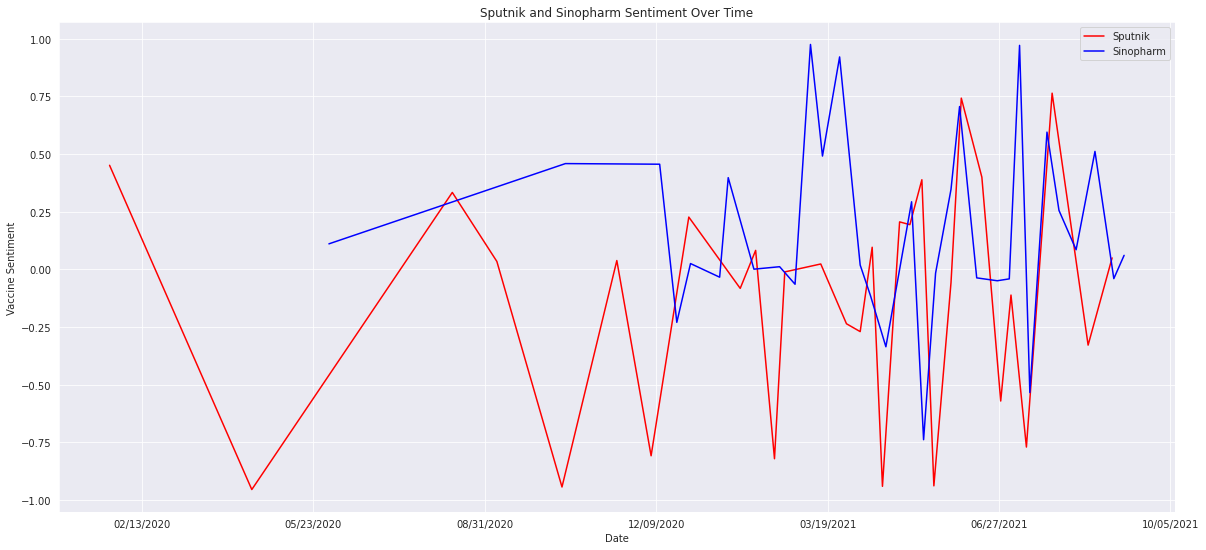

In [ ]:
# all the sentiments on one plot over time for the baseline
fig, ax = plt.subplots(figsize = (20, 10)) 
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(sputnik_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Sputnik and Sinopharm Sentiment Over Time")

ax.plot(sputnik_per_day["datetime"][::5],sputnik_per_day["sent_avg"][::5],'red', label='Sputnik')
ax.plot(sinopharm_per_day["datetime"][::5],sinopharm_per_day["sent_avg"][::5],'blue', label='Sinopharm')
leg = ax.legend()

# issue: how do we get this to extend to 2022 data as well??

In [ ]:
## xiaoyu's sentiment analysis of sputnik and sinophram

In [ ]:
# sputnik_per_day_alpha_beta = sputnik_per_day[32:37]
# sinopharm_per_day_alpha_beta = sinopharm_per_day[14:22]

sputnik_per_day_alpha_beta = sputnik_per_day[32:132]
sinopharm_per_day_alpha_beta = sinopharm_per_day[14:114]

In [ ]:
len(sputnik_per_day)

146

In [ ]:
# sputnik_per_day_gamma = sputnik_per_day[37:43]
# sinopharm_per_day_gamma = sinopharm_per_day[22:34]

sputnik_per_day_gamma = sputnik_per_day[37:137]
sinopharm_per_day_gamma = sinopharm_per_day[22:122]

In [ ]:
# sputnik_per_day_delta = sputnik_per_day[70:82]
# sinopharm_per_day_delta = sinopharm_per_day[65:76]

sputnik_per_day_delta = sputnik_per_day[70:172]
sinopharm_per_day_delta = sinopharm_per_day[65:165]

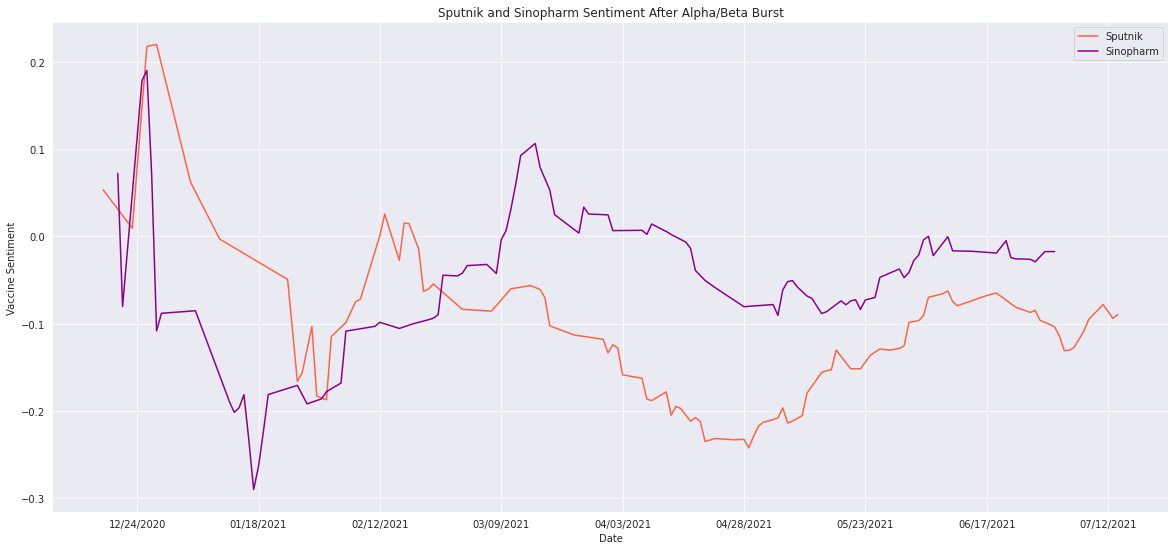

In [ ]:
# all the sentiments on one plot over time for the baseline
fig, ax = plt.subplots(1,1) 
fig.set_figheight(10)
fig.set_figwidth(20)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(sinopharm_per_day_alpha_beta["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()
plt.title("Sputnik and Sinopharm Sentiment After Alpha/Beta Burst")

ax.plot(sputnik_per_day_alpha_beta["datetime"],sputnik_per_day_alpha_beta["sent_avg"].ewm(span = 100).mean(),'tomato', label='Sputnik')
ax.plot(sinopharm_per_day_alpha_beta["datetime"],sinopharm_per_day_alpha_beta["sent_avg"].ewm(span = 100).mean(),'darkmagenta', label='Sinopharm')
leg = ax.legend()

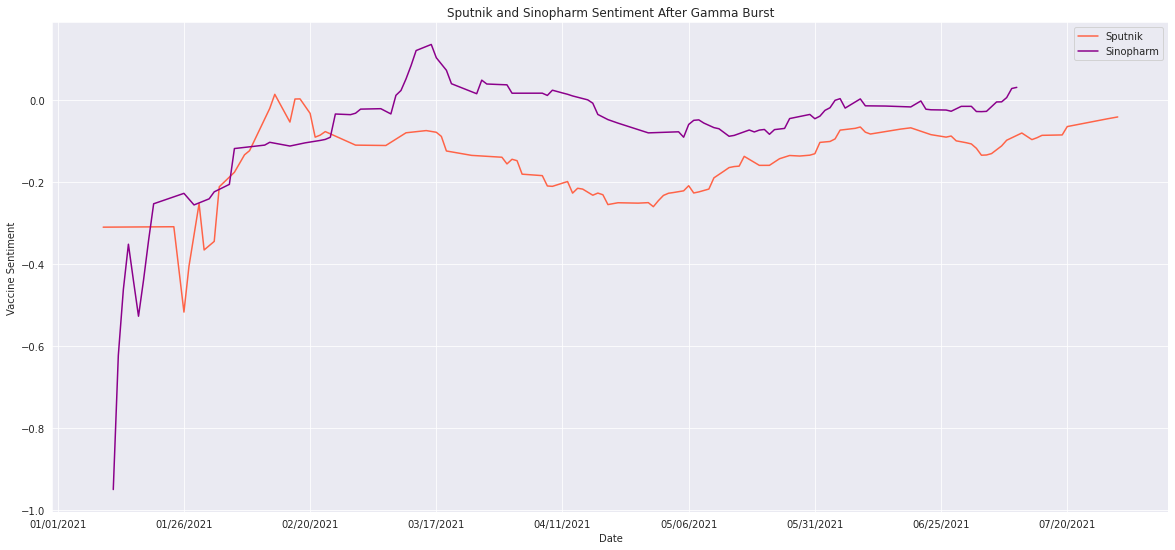

In [ ]:
# all the sentiments on one plot over time for the baseline
fig, ax = plt.subplots(1,1) 
fig.set_figheight(10)
fig.set_figwidth(20)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(sinopharm_per_day_gamma["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()
plt.title("Sputnik and Sinopharm Sentiment After Gamma Burst")

ax.plot(sputnik_per_day_gamma["datetime"],sputnik_per_day_gamma["sent_avg"].ewm(span = 100).mean(),'tomato', label='Sputnik')
ax.plot(sinopharm_per_day_gamma["datetime"],sinopharm_per_day_gamma["sent_avg"].ewm(span = 100).mean(),'darkmagenta', label='Sinopharm')
leg = ax.legend()

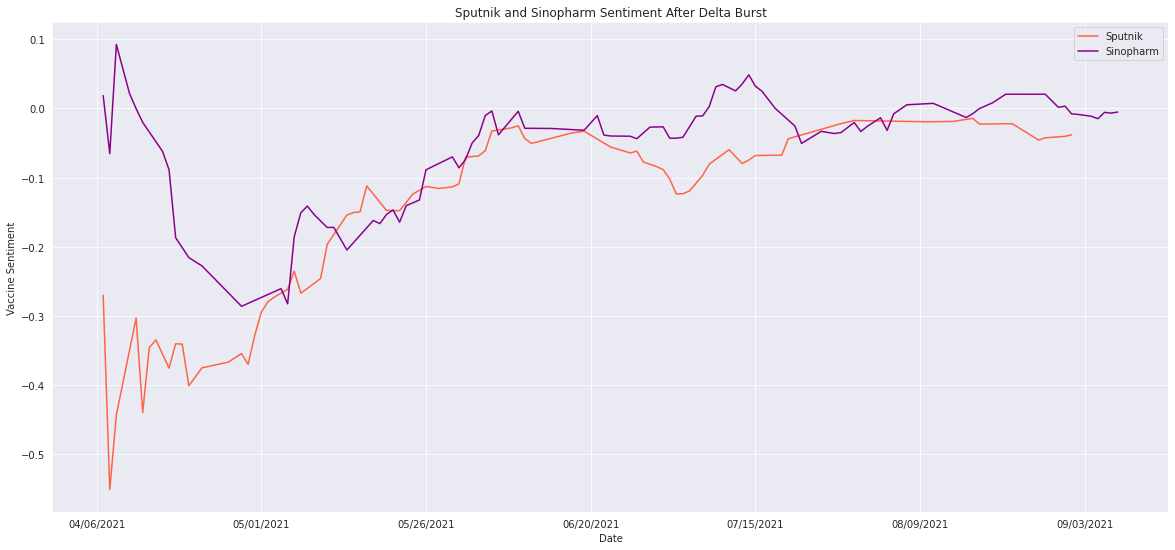

In [ ]:
# all the sentiments on one plot over time for the baseline
fig, ax = plt.subplots(1,1) 
fig.set_figheight(10)
fig.set_figwidth(20)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(sinopharm_per_day_delta["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()
plt.title("Sputnik and Sinopharm Sentiment After Delta Burst")

ax.plot(sputnik_per_day_delta["datetime"],sputnik_per_day_delta["sent_avg"].ewm(span = 100).mean(),'tomato', label='Sputnik')
ax.plot(sinopharm_per_day_delta["datetime"],sinopharm_per_day_delta["sent_avg"].ewm(span = 100).mean(),'darkmagenta', label='Sinopharm')
leg = ax.legend()

        month  sent_avg
0  2020-06-01  0.110592
1  2020-07-01  0.028397
2  2020-08-01  0.983541
3  2020-09-01  0.212803
4  2020-10-01  0.241593
5  2020-11-01 -0.069866
6  2020-12-01 -0.022841
7  2021-01-01 -0.238928
8  2021-02-01  0.124022
9  2021-03-01  0.115758
10 2021-04-01 -0.290446
11 2021-05-01 -0.004268
12 2021-06-01  0.056436
13 2021-07-01 -0.024674
14 2021-08-01  0.096577
15 2021-09-01 -0.056748


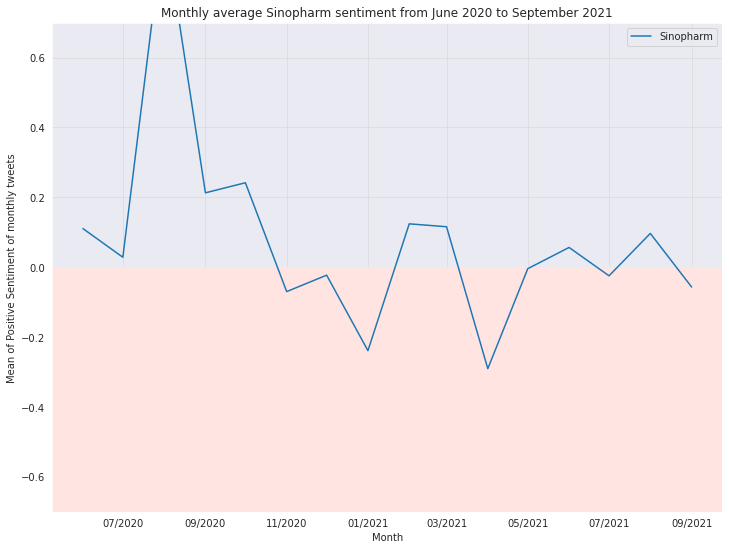

In [ ]:
# graphing mean of sentiment for each month of sinopharm
sinopharm_month = sinopharm_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

sinopharm_month["month"] = sinopharm_month["datetime"].apply(startMonth)

sinopharm_avg_month = sinopharm_month.groupby("month")["sent_avg"].mean().reset_index()

print(sinopharm_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Sinopharm sentiment from June 2020 to September 2021")
plt.plot(sinopharm_avg_month["month"],sinopharm_avg_month["sent_avg"], label='Sinopharm')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()


        month  sent_avg
0  2020-01-01  0.451401
1  2020-03-01 -0.463922
2  2020-04-01 -0.695486
3  2020-05-01  0.493347
4  2020-08-01 -0.231918
5  2020-09-01  0.182160
6  2020-10-01 -0.199407
7  2020-11-01 -0.196040
8  2020-12-01  0.054528
9  2021-01-01 -0.366196
10 2021-02-01  0.038103
11 2021-03-01 -0.267017
12 2021-04-01 -0.337414
13 2021-05-01  0.004864
14 2021-06-01 -0.022566
15 2021-07-01  0.083250
16 2021-08-01 -0.136058
17 2021-09-01  0.049624


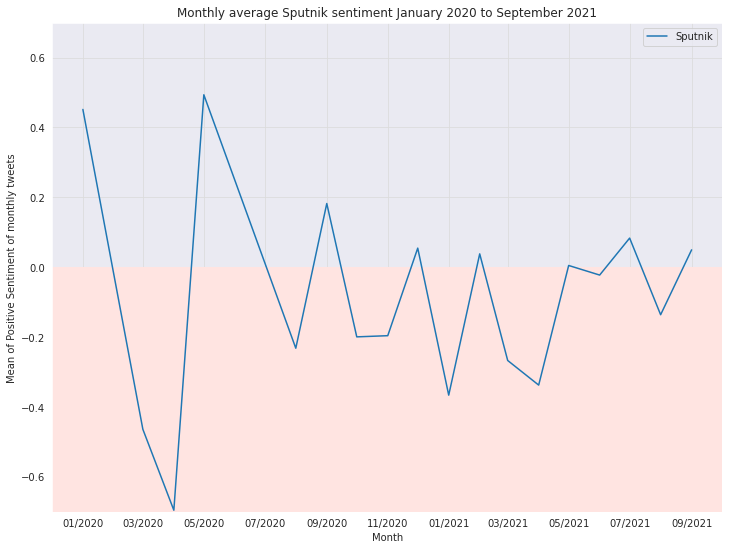

In [ ]:
# graphing mean of sentiment for each month of sputnik
sputnik_month = sputnik_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

sputnik_month["month"] = sputnik_month["datetime"].apply(startMonth)

sputnik_avg_month = sputnik_month.groupby("month")["sent_avg"].mean().reset_index()

print(sputnik_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Sputnik sentiment January 2020 to September 2021")
plt.plot(sputnik_avg_month["month"],sputnik_avg_month["sent_avg"], label='Sputnik')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

        month  sent_avg
0  2020-02-01  0.164573
1  2020-03-01  0.103337
2  2020-04-01  0.352676
3  2020-05-01  0.349615
4  2020-06-01  0.163418
5  2020-07-01  0.076373
6  2020-08-01 -0.213337
7  2020-09-01  0.311562
8  2020-10-01 -0.324543
9  2020-11-01 -0.022509
10 2020-12-01  0.193292
11 2021-01-01  0.096782
12 2021-02-01  0.199908
13 2021-03-01  0.187061
14 2021-04-01  0.202804
15 2021-05-01  0.211531
16 2021-06-01 -0.074292
17 2021-07-01 -0.041315
18 2021-08-01 -0.042293
19 2021-09-01  0.130832


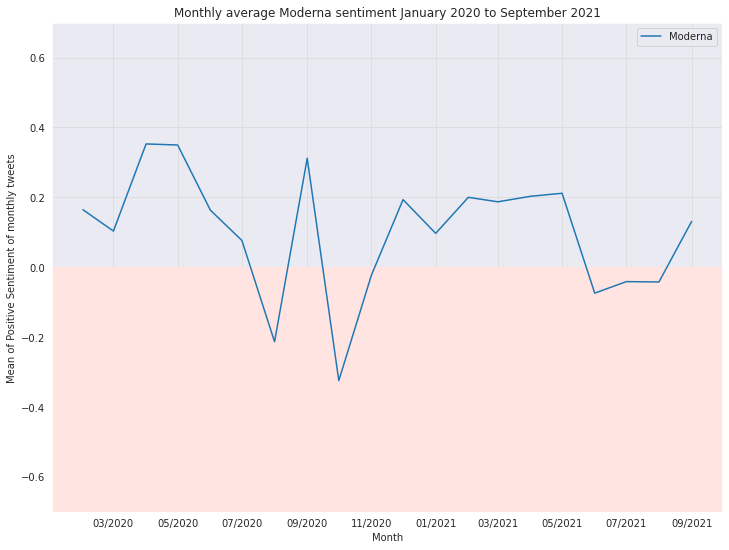

In [ ]:
# graphing mean of sentiment for each month of moderna
moderna_month = moderna_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

moderna_month["month"] = moderna_month["datetime"].apply(startMonth)

moderna_avg_month = moderna_month.groupby("month")["sent_avg"].mean().reset_index()

print(moderna_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Moderna sentiment January 2020 to September 2021")
plt.plot(moderna_avg_month["month"],moderna_avg_month["sent_avg"], label='Moderna')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

        month  sent_avg
0  2020-03-01  0.115972
1  2020-04-01  0.212525
2  2020-05-01  0.118104
3  2020-06-01  0.061403
4  2020-07-01  0.070453
5  2020-08-01  0.036093
6  2020-09-01 -0.139961
7  2020-10-01  0.037800
8  2020-11-01 -0.099095
9  2020-12-01  0.042359
10 2021-01-01 -0.026963
11 2021-02-01  0.094260
12 2021-03-01  0.087639
13 2021-04-01  0.115131
14 2021-05-01  0.065738
15 2021-06-01  0.070281
16 2021-07-01 -0.075193
17 2021-08-01 -0.102273
18 2021-09-01 -0.115994


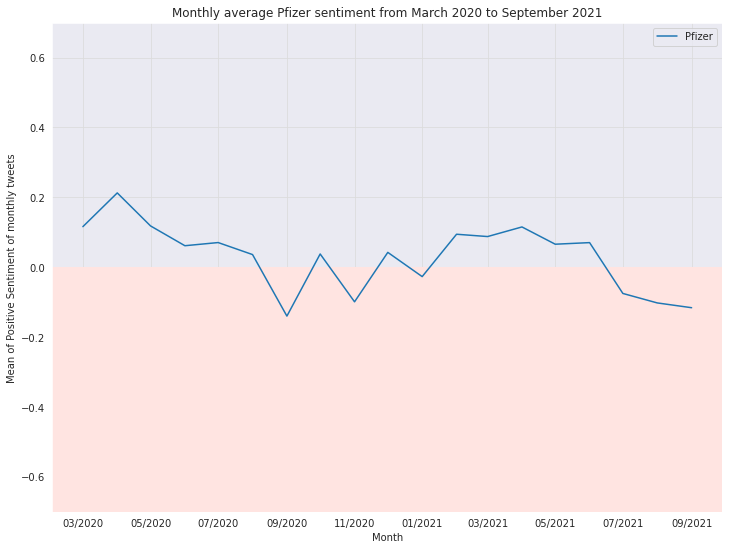

In [ ]:
# graphing mean of sentiment for each month of pfizer
pfizer_month = pfizer_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

pfizer_month["month"] = pfizer_month["datetime"].apply(startMonth)

pfizer_avg_month = pfizer_month.groupby("month")["sent_avg"].mean().reset_index()

print(pfizer_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Pfizer sentiment from March 2020 to September 2021")
plt.plot(pfizer_avg_month["month"],pfizer_avg_month["sent_avg"], label='Pfizer')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

        month  sent_avg
0  2020-03-01  0.088646
1  2020-04-01  0.129511
2  2020-05-01 -0.886841
3  2020-06-01  0.331184
4  2020-07-01  0.085570
5  2020-08-01  0.203954
6  2020-09-01  0.083799
7  2020-10-01 -0.265645
8  2020-11-01  0.136152
9  2020-12-01  0.163285
10 2021-01-01 -0.010868
11 2021-02-01  0.078266
12 2021-03-01 -0.030107
13 2021-04-01 -0.055635
14 2021-05-01  0.139972
15 2021-06-01 -0.034544
16 2021-07-01  0.144243
17 2021-08-01 -0.112987
18 2021-09-01 -0.226230


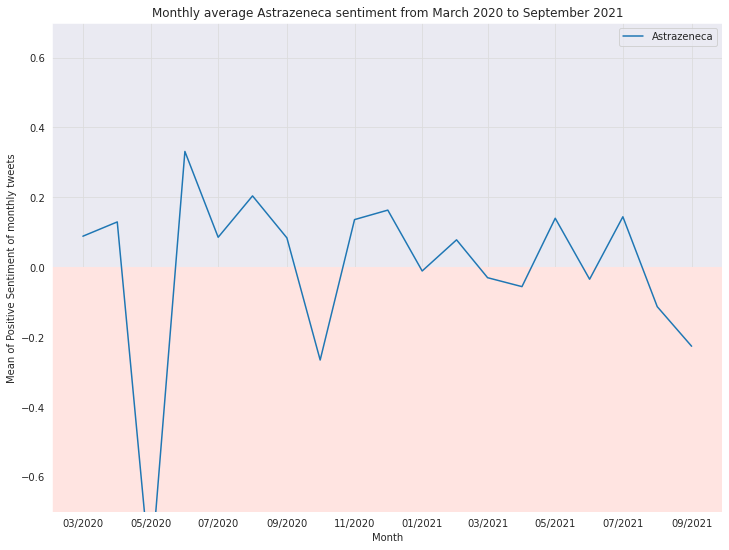

In [ ]:
# graphing mean of sentiment for each month of astrazeneca
astra_month = astra_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

astra_month["month"] = astra_month["datetime"].apply(startMonth)

astra_avg_month = astra_month.groupby("month")["sent_avg"].mean().reset_index()

print(astra_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Astrazeneca sentiment from March 2020 to September 2021")
plt.plot(astra_avg_month["month"],astra_avg_month["sent_avg"], label='Astrazeneca')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

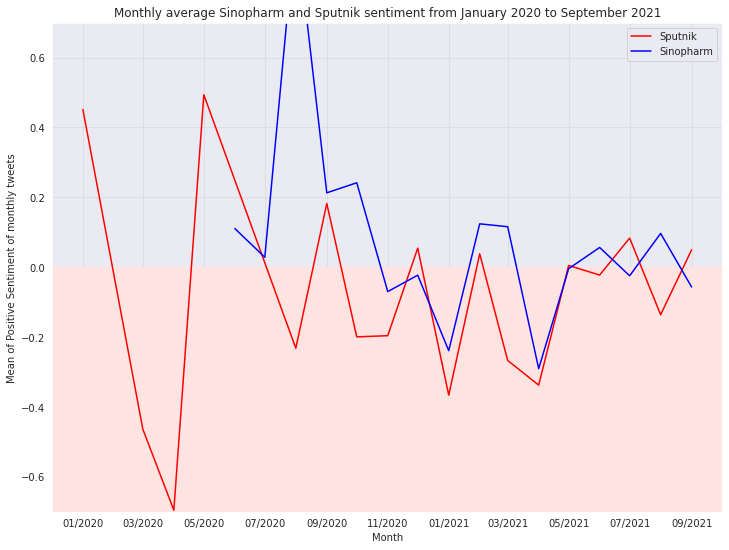

In [ ]:
# graphing mean of sentiment for each month of sputnik and sinopharm

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Sinopharm and Sputnik sentiment from January 2020 to September 2021")
ax.plot(sputnik_avg_month["month"],sputnik_avg_month["sent_avg"],'red', label='Sputnik')
ax.plot(sinopharm_avg_month["month"],sinopharm_avg_month["sent_avg"],'blue', label='Sinopharm')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

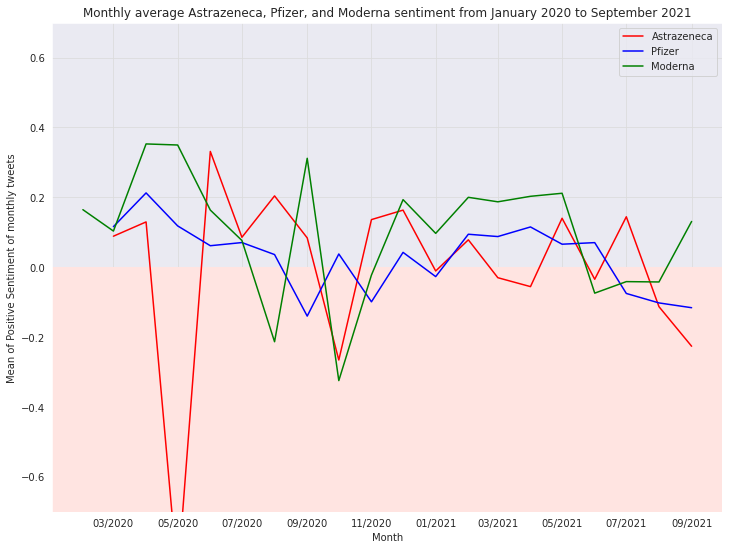

In [ ]:
# graphing mean of sentiment for each month of moderna, pfizer and astrazeneca

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Astrazeneca, Pfizer, and Moderna sentiment from January 2020 to September 2021")
ax.plot(astra_avg_month["month"],astra_avg_month["sent_avg"],'red', label='Astrazeneca')
ax.plot(pfizer_avg_month["month"],pfizer_avg_month["sent_avg"],'blue', label='Pfizer')
ax.plot(moderna_avg_month["month"],moderna_avg_month["sent_avg"],'green', label='Moderna')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

In [ ]:
# Function to get data by month for a given dataframe
def get_data_for_months(dataframe):
  months_dict = {}
  months = dataframe.month.unique()
  for month in months:
    years = month.astype('datetime64[Y]').astype(int) + 1970
    months = month.astype('datetime64[M]').astype(int) % 12 + 1
    # We only look at certain months to compare to the other paper
    if((months == 12 and years == 2020) or (months == 1 and years == 2021) or (months == 2 and years == 2021) or (months == 3 and years == 2021)):
      months_dict[month] = dataframe.loc[dataframe["month"] == month]["sent_val"]

  data_arr = []
  months_arr = []
  for month in sorted(months_dict.keys()):
    years = month.astype('datetime64[Y]').astype(int) + 1970
    months = month.astype('datetime64[M]').astype(int) % 12 + 1
    if((months == 12 and years == 2020) or (months == 1 and years == 2021) or (months == 2 and years == 2021) or (months == 3 and years == 2021)):
      data_arr.append(months_dict[month])
      months_arr.append(str(month)[0:7])

  return data_arr, months_arr

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


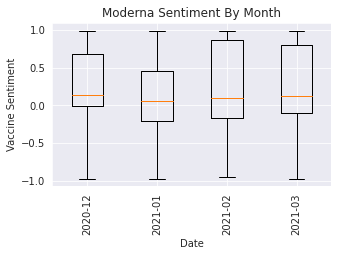

In [ ]:
# Create box plot of vaccine sentiment by month for moderna
moderna_df = moderna_df.rename(columns={"sent_avg": "sent_val"})
moderna_df["month"] = moderna_df["datetime"].apply(startMonth)

data_arr, months_arr = get_data_for_months(moderna_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Moderna Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


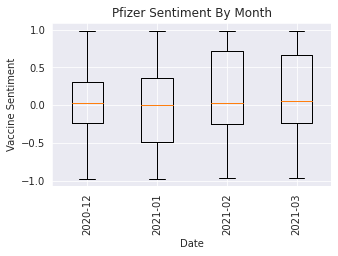

In [ ]:
# Create box plot of vaccine sentiment by month for pfizer
pfizer_df = pfizer_df.rename(columns={"sent_avg": "sent_val"})
pfizer_df["month"] = pfizer_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(pfizer_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Pfizer Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


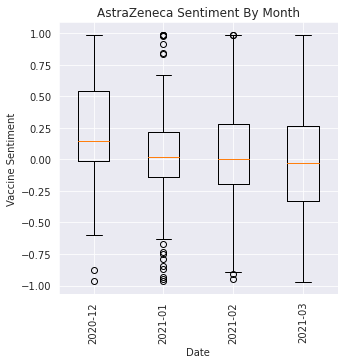

In [ ]:
# Create box plot of vaccine sentiment by month for astrazeneca
astra_df = astra_df.rename(columns={"sent_avg": "sent_val"})
astra_df["month"] = astra_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(astra_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(5)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("AstraZeneca Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


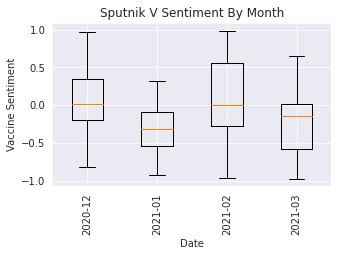

In [ ]:
# Create box plot of vaccine sentiment by month for sputnik
sputnik_df = sputnik_df.rename(columns={"sent_avg": "sent_val"})
sputnik_df["month"] = sputnik_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(sputnik_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Sputnik V Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


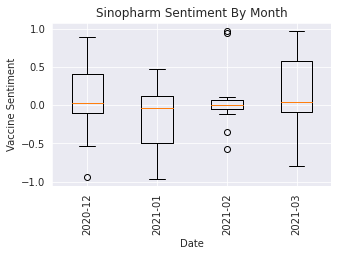

In [ ]:
# Create box plot of vaccine sentiment by month for sinopharm
sinopharm_df = sinopharm_df.rename(columns={"sent_avg": "sent_val"})
sinopharm_df["month"] = sinopharm_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(sinopharm_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Sinopharm Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

In [ ]:
# Create dataframe with count of tweets per month for each brand
moderna_month_count_df = moderna_df.groupby("month").count()
pfizer_month_count_df = pfizer_df.groupby("month").count()
astra_month_count_df = astra_df.groupby("month").count()
sputnik_month_count_df = sputnik_df.groupby("month").count()
sinopharm_month_count_df = sinopharm_df.groupby("month").count()

In [ ]:
# Create dataframe with count of tweets per month for total dataset
all_tweets_df["month"] = all_tweets_df["datetime"].apply(startMonth)
all_month_count_df = all_tweets_df.groupby("month").count()

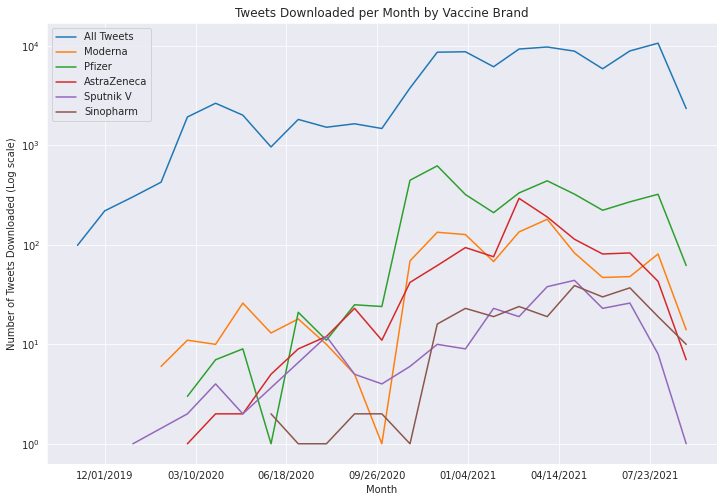

In [ ]:
# Plot how many tweets we downloaded per month for each brand
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Number of Tweets Downloaded (Log scale)")
plt.yscale("log")
plt.xticks(astra_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Tweets Downloaded per Month by Vaccine Brand")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(all_month_count_df.index, all_month_count_df["tweet_text"])
plt.plot(moderna_month_count_df.index, moderna_month_count_df["tweet_text"])
plt.plot(pfizer_month_count_df.index, pfizer_month_count_df["tweet_text"])
plt.plot(astra_month_count_df.index, astra_month_count_df["tweet_text"])
plt.plot(sputnik_month_count_df.index, sputnik_month_count_df["tweet_text"])
plt.plot(sinopharm_month_count_df.index, sinopharm_month_count_df["tweet_text"])
plt.legend(["All Tweets", "Moderna", "Pfizer", "AstraZeneca", "Sputnik V", "Sinopharm"])
plt.show()

In [ ]:
pfizer_per_day

,datetime,tweet_text,time,coords,tweet_id,sentiment,sent_avg,sent_var
0,2020-03-20,1,1,1,1,1,0.125461,NaN
1,2020-03-31,2,2,2,2,2,0.106483,0.000428
2,2020-04-02,2,2,2,2,2,0.124420,0.003498
3,2020-04-03,2,2,2,2,2,-0.443883,0.501247
4,2020-04-22,1,1,1,1,1,0.866304,NaN
...,...,...,...,...,...,...,...,...
364,2021-09-05,5,5,5,5,5,-0.075924,0.344826
365,2021-09-06,7,7,7,7,7,-0.581074,0.146324
366,2021-09-07,6,6,6,6,6,-0.106118,0.168601
367,2021-09-08,8,8,8,8,8,-0.032835,0.485291
